# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [1]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2'
DATASET_PATH = 'data/dataset.txt'

# For some reason, the splicebert model doesn't work when this is set to 1024
# (even tho max input length in docs say 1024 is max length)
MODEL_MAX_INPUT_SIZE = 512

MULTIMOLECULE_MODEL = "splicebert"
SAMPLE_N_DATAPOINTS = 500 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [2]:
%%capture
!pip install datasets evaluate multimolecule

In [3]:
import pandas as pd
import torch
from transformers import (
#     AutoTokenizer,
#     AutoModel,
#     AutoModelForMaskedLM,
#     AutoModelForTokenClassification,
     DataCollatorForTokenClassification,
     TrainingArguments,
     Trainer
)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import *
from BP_LM.scripts.compute_metrics import *

Mounted at /content/drive
/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2


## Load the desired model and tokenizer

In [6]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, SpliceBertForTokenPrediction

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want
model = SpliceBertForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/78.9M [00:00<?, ?B/s]

Some weights of SpliceBertForTokenPrediction were not initialized from the model checkpoint at multimolecule/splicebert and are newly initialized: ['splicebert.pooler.dense.bias', 'splicebert.pooler.dense.weight', 'token_head.decoder.bias', 'token_head.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create dataset objects for training

In [7]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

Chromosomes in train set: {'chr17', 'chr19', 'chrY', 'chr13', 'chr6', 'chrX', 'chr5', 'chr4', 'chr12', 'chr21', 'chr7', 'chr15', 'chr1', 'chr3', 'chr16', 'chr22', 'chr20', 'chr18', 'chr14', 'chr2'}
Chromosomes in validation set: {'chr10', 'chr9'}
Chromosomes in test set: {'chr11', 'chr8'}

Total data points: 500
Train set contains 400 data points (80.00%)
Validation set contains 44 data points (8.80%)
Test set contains 56 data points (11.20%)


## Train model

In [8]:
# Set up the collator (I think it does padding)
data_collator = DataCollatorForTokenClassification(tokenizer) #Unsure about how data_collator pads exactly so i specified padding in the tokenizer itself


In [9]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [10]:
# Define model training parameters
batch_size = 4

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

<ipython-input-11-66170a759659>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
1,No log,0.015527,0.013201,0.000000,0.002390,0.004467,0.505308,0.002752


/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2/BP_LM/scripts/compute_metrics.py:55: RuntimeWarning: invalid value encountered in divide
  ideal_threshold = thresholds[np.nanargmax(2 * (precision * recall) / (precision + recall))]
/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2/BP_LM/scripts/compute_metrics.py:56: RuntimeWarning: invalid value encountered in divide
  F1 = np.nanmax(2 * (precision * recall) / (precision + recall))


TrainOutput(global_step=100, training_loss=0.02785390377044678, metrics={'train_runtime': 9.4986, 'train_samples_per_second': 42.112, 'train_steps_per_second': 10.528, 'total_flos': 23659226736000.0, 'train_loss': 0.02785390377044678, 'epoch': 1.0})

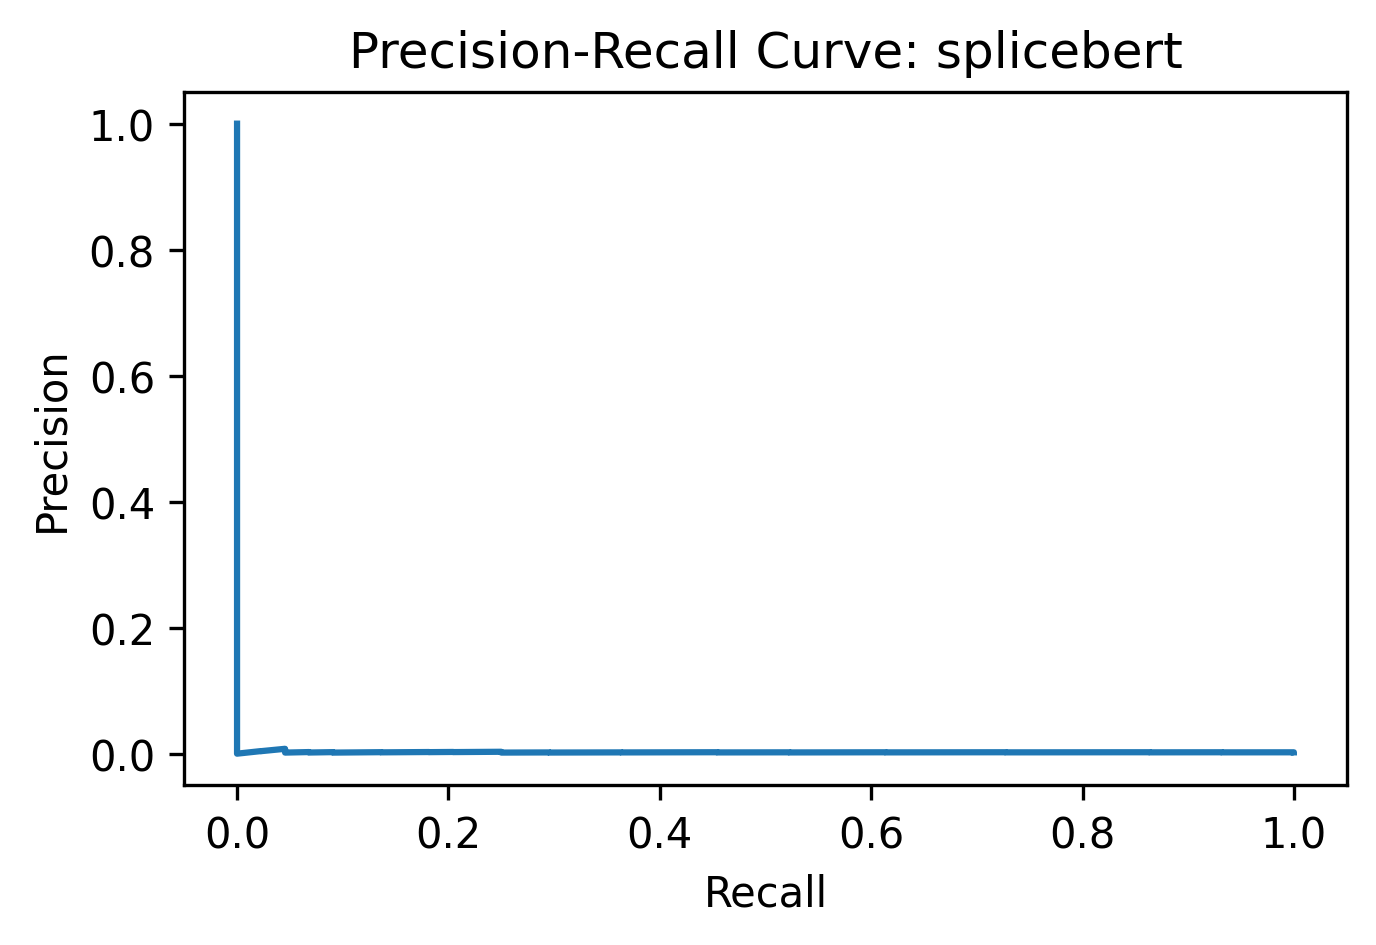

In [11]:
metrics = lambda x: compute_metrics(x, MULTIMOLECULE_MODEL)
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [17]:
trained_model = SpliceBertForTokenPrediction.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-100") #make sure you are loading the right checkpoint
tokenizer = RnaTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-100")
data_collator = DataCollatorForTokenClassification(tokenizer)

<ipython-input-18-afc75ba886bc>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tester = Trainer(


Evaluation Metrics:
eval_loss: 0.015998391434550285
eval_model_preparation_time: 0.0019
eval_F1: 0.0
eval_Seq. Acc: 0.0
eval_AP: 0.0024665001400348257
eval_MCC: -0.0033613855409848114
eval_AUC: 0.49741375957686773
eval_runtime: 0.4678
eval_samples_per_second: 119.715
eval_steps_per_second: 29.929


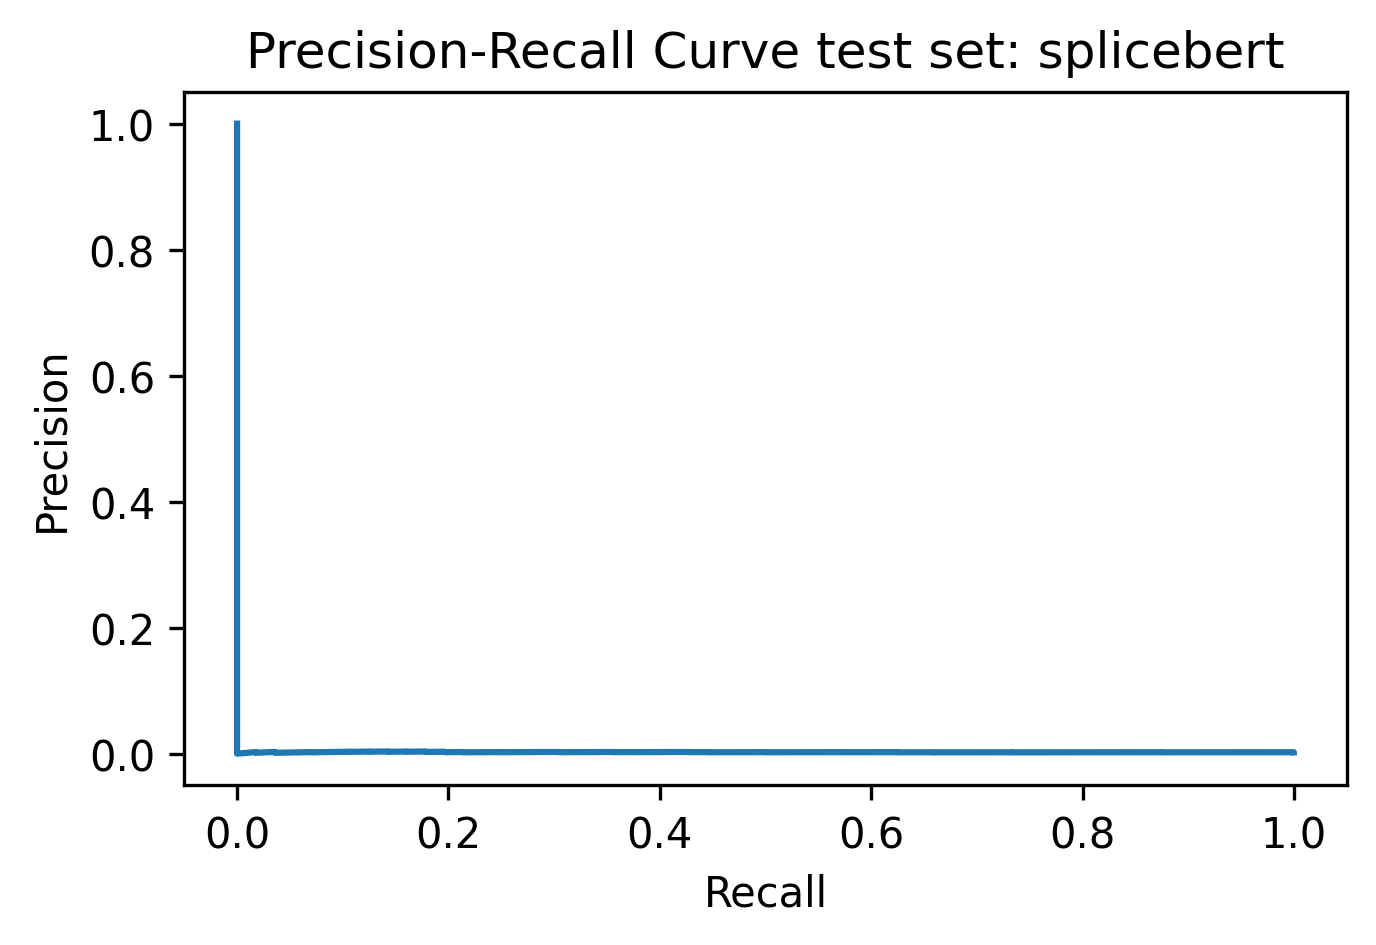

In [18]:
metric = lambda x: compute_metrics_test(x, MULTIMOLECULE_MODEL, 0.002752)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")